In [1]:
import os 
from glob import glob
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
import gsw
import datetime
%matplotlib inline

In [2]:
#read channel and cavity data from .csv files into pandas dataframes

sbd =pd.read_csv('amigos3c_channel_sbd.csv', header=1, names = ['timestamp', 'station', 'ID', 'Conductivity', 'Temp',
                                                     'Pressure', 'Salinity'])
                                                
sbd_cav =pd.read_csv('amigos3a_cavity_sbd.csv', header=1, names = ['timestamp', 'station', 'ID', 'Conductivity', 'Temp',
                                                     'Pressure', 'Salinity'])
sbd = sbd.append(sbd_cav)

In [3]:
# import Hugin data

hugin = pd.read_csv('CTDO2_NBP19_02_011.csv', header=1, names = ['timestamp', 'Lat', 'Long', 'press', 'SA', 'CT', 'O2', 'mat_time'])

In [4]:
# convert the time data into python datetime format and add a fraction day-of-year field, counting from Jan 1, 2020

hugin['datetime']=pd.to_datetime(hugin.timestamp, format = '%d-%b-%Y %H:%M:%S ')
hugin['doy'] = hugin.datetime.dt.dayofyear + (hugin.datetime.dt.hour+hugin.datetime.dt.minute/60)/24

sbd['datetime']=pd.to_datetime(sbd.timestamp, format = '%Y-%m-%d %H:%M:%S')
sbd['doy'] = (sbd.datetime.dt.year-2020)*365 + sbd.datetime.dt.dayofyear + (sbd.datetime.dt.hour+sbd.datetime.dt.minute/60)/24

In [8]:
def TS_diagram(sbd, sensor, start, end):
    
    # plot a salinity temperature graph for a given sensor number  (Can be more than one) with specified start/end dates (doy)
    
    instr = sbd[sbd.ID.isin(sensor)]
    
    # need to convert the dataframe series to numpy arrays for the GSW Toolbox
    
    SP = instr.Salinity.to_numpy()
    T = instr.Temp.to_numpy()
    p = instr.Pressure.to_numpy()
    doy = instr.doy.to_numpy()
    
    # use the Gibbs Seawater Toolbox to calculate Conservative Temperature and Absolute Salinity
    
    SA = gsw.SA_from_SP(SP,p,-111.9,-74.9)
    CT = gsw.CT_from_t(SA,T,p)
    
    plt.figure(figsize=(12,9))
    
    plt.scatter(SA[(doy > start)&(doy < end)],CT[(doy>start)&(doy<end)],5,doy[(doy>start)&(doy<end)])
    cb = plt.colorbar()
    cb.set_label(label='DOY', fontsize=16)
    cb.ax.tick_params(labelsize=16)
    
    plt.ylabel('Cons. Temp ($^oC$)', fontsize=16)
    plt.xlabel('Abs. Sal.', fontsize=16)
    
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16) 
    
    plt.title('CTD Number ' + str(sensor), fontsize=18)
    
    return

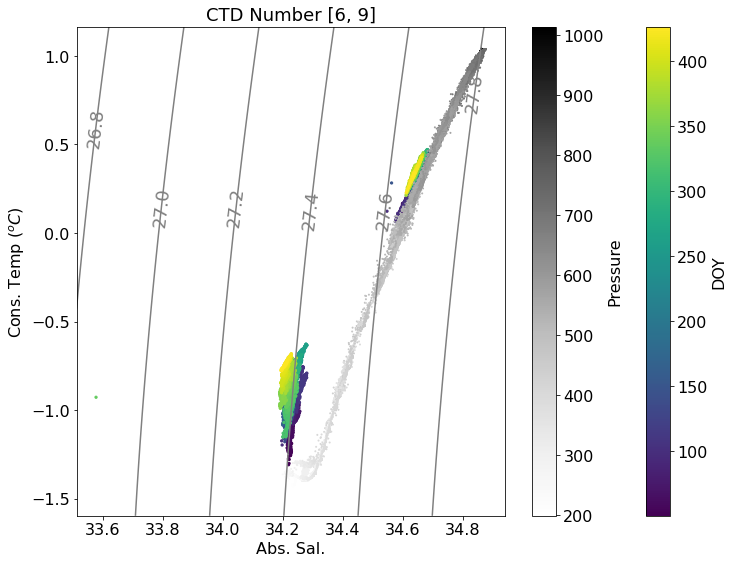

In [39]:
# This block plots AMIGOS data and Hugin data

# Sensor numbers are as follows (from top down): Cavity 5,6,7; Channel: 8,9,80

# plot a list of sensors (can be more than one)
TS_diagram(sbd,[6,9], 50, 500)

# for some reason the Hugin data is read in as a string, so it needs to be converted to numbers
SA_h = hugin.SA.to_numpy().astype(np.float64)
CT_h = hugin.CT.to_numpy().astype(np.float64)
press_h = hugin.press.to_numpy()

# plot all Hugin data above the specified salinity limit

salt_lim = 30
ph = plt.scatter(SA_h[SA_h > salt_lim],CT_h[SA_h > salt_lim],1,press_h[SA_h > salt_lim], cmap='Greys')
cb_h = plt.colorbar(ph)
cb_h.set_label(label='Pressure', fontsize=16)
cb_h.ax.tick_params(labelsize=16)

# plot isopycnals

# reference pressure
pref = 0

SAmin, SAmax = plt.xlim()
CTmin, CTmax = plt.ylim()

tempL=np.linspace(CTmin,CTmax,156)
salL=np.linspace(SAmin,SAmax,156)

Tg, Sg = np.meshgrid(tempL,salL)
sigma_theta = gsw.rho(Sg, Tg,pref)-1000

cs = plt.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1)
cl=plt.clabel(cs,fontsize=18,inline=False,fmt='%.1f')

# this is only for saving a figure
#plt.savefig('Amigos_Hugin_midwater.png')

In [42]:
def TS_plot(sbd, sensor, start, end, anomaly=True):
    
    # plot time series of anomalies or actual values (default: anomaly)
    # start and end days can be specified
    
    fig, ax1 = plt.subplots(figsize=(20,9))
    
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16) 
    
    ax2 = ax1.twinx()
    
    # plot a salinity temperature graph for a given sensor
    for sn in sensor:
        instr = sbd[sbd.ID == sn]
        #instr = sbd[sbd.ID.isin(sn)]
        SP = instr.Salinity.to_numpy()
        T = instr.Temp.to_numpy()
        p = instr.Pressure.to_numpy()
        doy = instr.doy.to_numpy()
    
        SA = gsw.SA_from_SP(SP,p,-111.9,-74.9)
        CT = gsw.CT_from_t(SA,T,p)
        
        if anomaly:
            T_label = 'Sensor ' + str(sn) + '  Temp. mean: ' + "{:4.2f}".format(np.mean(CT[(doy>start)&(doy<end)]))
            ax1.plot(doy[(doy > start)&(doy < end)],CT[(doy>start)&(doy<end)]-np.mean(CT[(doy>start)&(doy<end)]), label=T_label)
         
            S_label = 'Sensor ' + str(sn) + '  Salt. mean: ' + "{:4.2f}".format(np.mean(SA[(doy>start)&(doy<end)]))
            ax2.plot(doy[(doy > start)&(doy < end)],SA[(doy>start)&(doy<end)]-np.mean(SA[(doy>start)&(doy<end)]),':', label=S_label)

        else:
            
            T_label = 'Sensor ' + str(sn)
            ax1.plot(doy[(doy > start)&(doy < end)],CT[(doy>start)&(doy<end)], label=T_label)
         
            S_label = 'Sensor ' + str(sn)
            ax2.plot(doy[(doy > start)&(doy < end)],SA[(doy>start)&(doy<end)],':', label=S_label)
   
        plt.yticks(fontsize=16) 
    
        plt.xlabel('DOY', fontsize=16)
        ax1.set_ylabel('Cons. Temp.', fontsize=16)
        ax2.set_ylabel('Abs. Sal.', fontsize=16)
    
    plt.title('CTD Number ' + str(sensor), fontsize=18)
    ax1.legend(fontsize=18, loc = 'upper right', bbox_to_anchor = (0.98,0.98))
    ax2.legend(fontsize=18, loc = 'upper right', bbox_to_anchor = (0.98,0.85))
    
    return

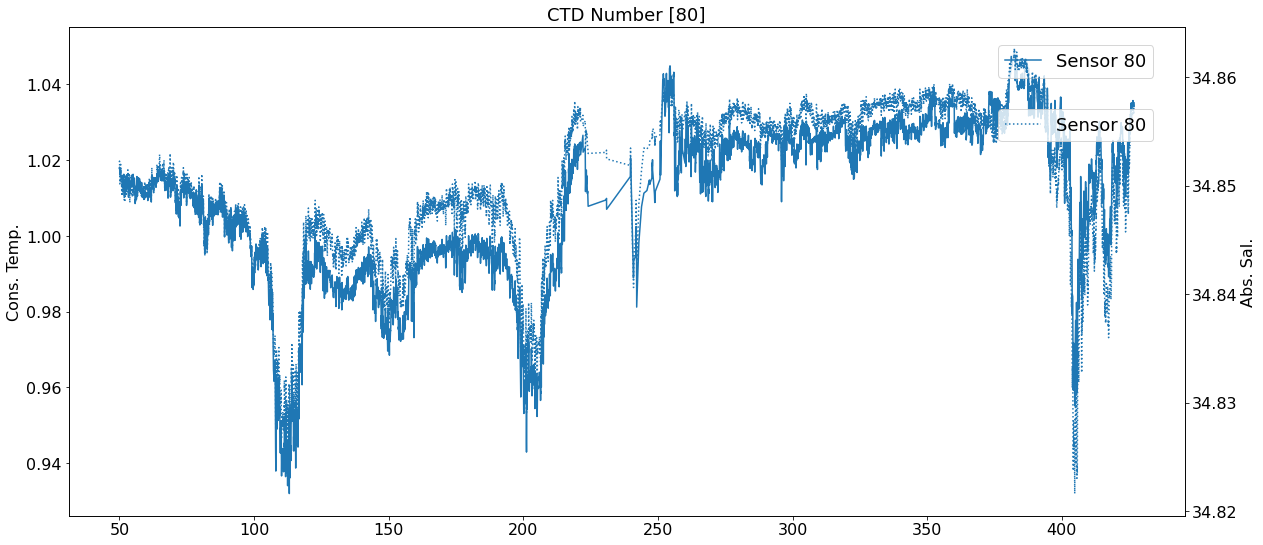

In [45]:
leg = TS_plot(sbd,[80],50,500, False)

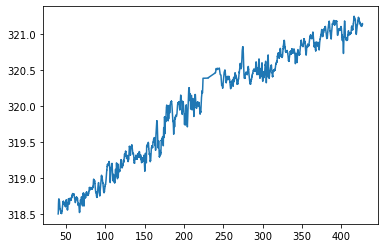

In [46]:
instr = sbd[sbd.ID == 9]
p = instr.Pressure.to_numpy()
doy = instr.doy.to_numpy()

start = 40
end = 500
#SA = gsw.SA_from_SP(SP,p,-111.9,-74.9)
#CT = gsw.CT_from_t(SA,T,p)
    
plt.plot(doy[(doy > start)&(doy < end)],p[(doy>start)&(doy<end)])
     